In [1]:
trace_file = 'trace_mpi_0.csv'
archive = 'grenoble_2018-12-03_1822096.zip'

## Simulation

In [2]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def read_mpi_state(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function', 'tmp'],
                  filter_func=lambda x: filter_pajeng(x, 'State'))
    df['msg_size'] = -1
    df['rank'] = df['rank'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['function'] = df['function'].str.replace('PMPI', 'MPI').str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
    df['msg_size'] = df['msg_size'].astype(int)
    return df

def read_mpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
df_state = read_mpi_state(archive, trace_file)
df_state.head()

,type,rank,container,start,end,duration,level,function,tmp,msg_size
0,State,98,MPI_STATE,0.000000,0.000000,0.000000,0.0,MPI_Init,NA,-1
1,State,98,MPI_STATE,0.000000,0.000008,0.000008,0.0,computing,0.000008,-1
2,State,98,MPI_STATE,0.000008,0.000010,0.000002,0.0,MPI_Recv,4,4
3,State,98,MPI_STATE,0.000010,0.000012,0.000002,0.0,computing,0.000002,-1
4,State,98,MPI_STATE,0.000012,0.000013,0.000001,0.0,MPI_Send,4,4


In [4]:
df_link  = read_mpi_link(archive, trace_file)
df_link.head()

,type,level,container,start,end,duration,commType,src,dst,msg_size,remote
0,Link,0,MPI_LINK,0.000006,0.000008,0.000002,PTP,249,248,4,False
1,Link,0,MPI_LINK,0.000006,0.000008,0.000002,PTP,245,244,4,False
2,Link,0,MPI_LINK,0.000007,0.000008,0.000001,PTP,247,246,4,False
3,Link,0,MPI_LINK,0.000007,0.000008,0.000001,PTP,251,250,4,False
4,Link,0,MPI_LINK,0.000007,0.000008,0.000001,PTP,233,232,4,False


In [5]:
def draw_plot(state_dataframe, link_dataframe, time_interval=None, ranks=None):
    if time_interval is None:
        time_interval = -float('inf'), float('inf')
        time_str = 'for the whole experiment'
    else:
        time_str = 'between %.1fs and %.1fs' % time_interval
    if ranks is None:
        ranks = range(0, 1000000)
        rank_str = 'for all the ranks'
    else:
        rank_str = 'for ranks in %s' % ranks
    tmp_state = state_dataframe[(state_dataframe['start'] >= time_interval[0]) & (state_dataframe['end'] <= time_interval[1]) & (state_dataframe['rank'].isin(ranks))].copy()
    tmp_state['rank+1'] = tmp_state['rank'] + 1
    tmp_link = link_dataframe[(link_dataframe['start'] >= time_interval[0]) & (link_dataframe['end'] <= time_interval[1]) & (link_dataframe['src'].isin(ranks)) & (link_dataframe['dst'].isin(ranks))]

    gc = ggplot(tmp_state) + \
        geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) +\
        theme_bw() + xlab('Time') + ylab('Rank') + theme() + ggtitle('Events %s %s' % (time_str, rank_str))
    for i in set((tmp_state['rank'] // 32)*32):
        if i <= 0:
            continue
        gc += geom_hline(yintercept=i, linetype='dashed', color='red')
    print(gc)
    gc += geom_segment(tmp_link, aes(x = 'start', y = 'src', xend = 'end', yend = 'dst', color='remote'), arrow = arrow(length = 0.1))
    print(gc)

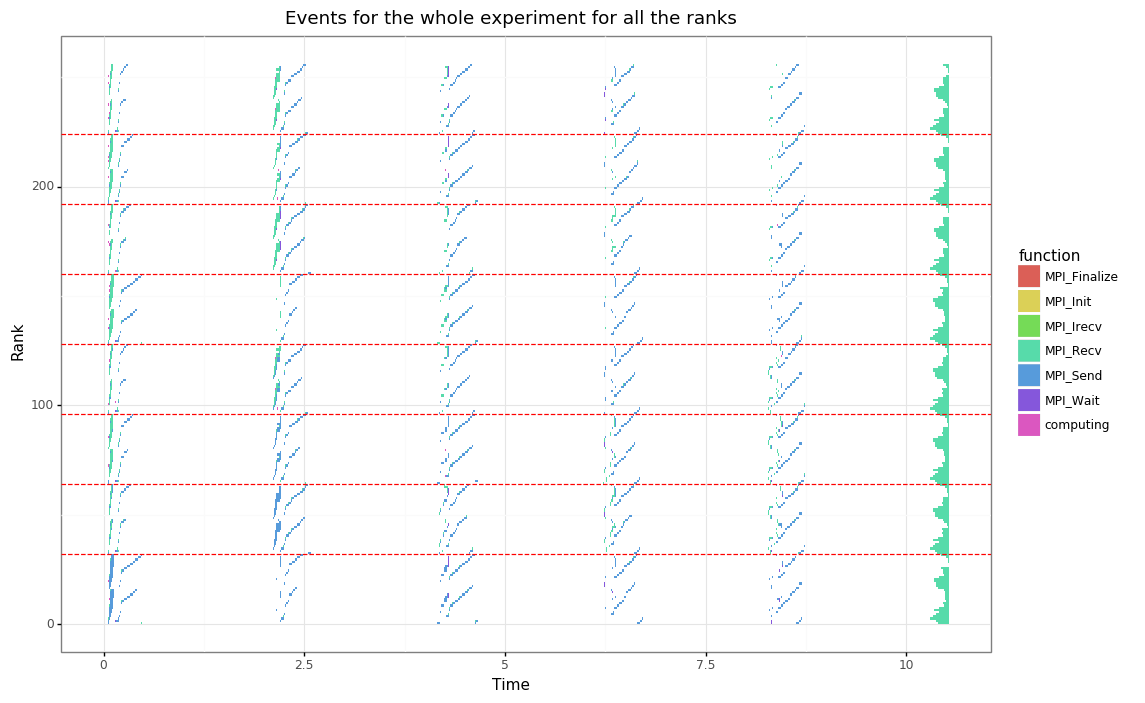

<ggplot: (-9223363251258424355)>


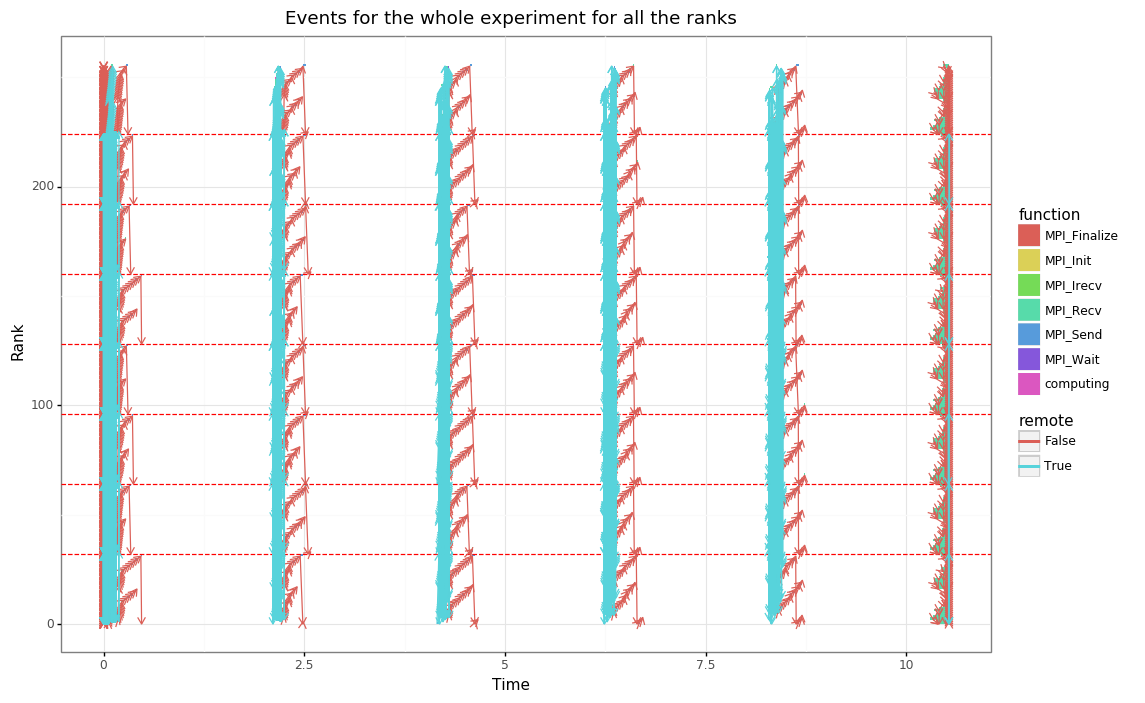

<ggplot: (-9223363251258424355)>


In [6]:
draw_plot(df_state, df_link)

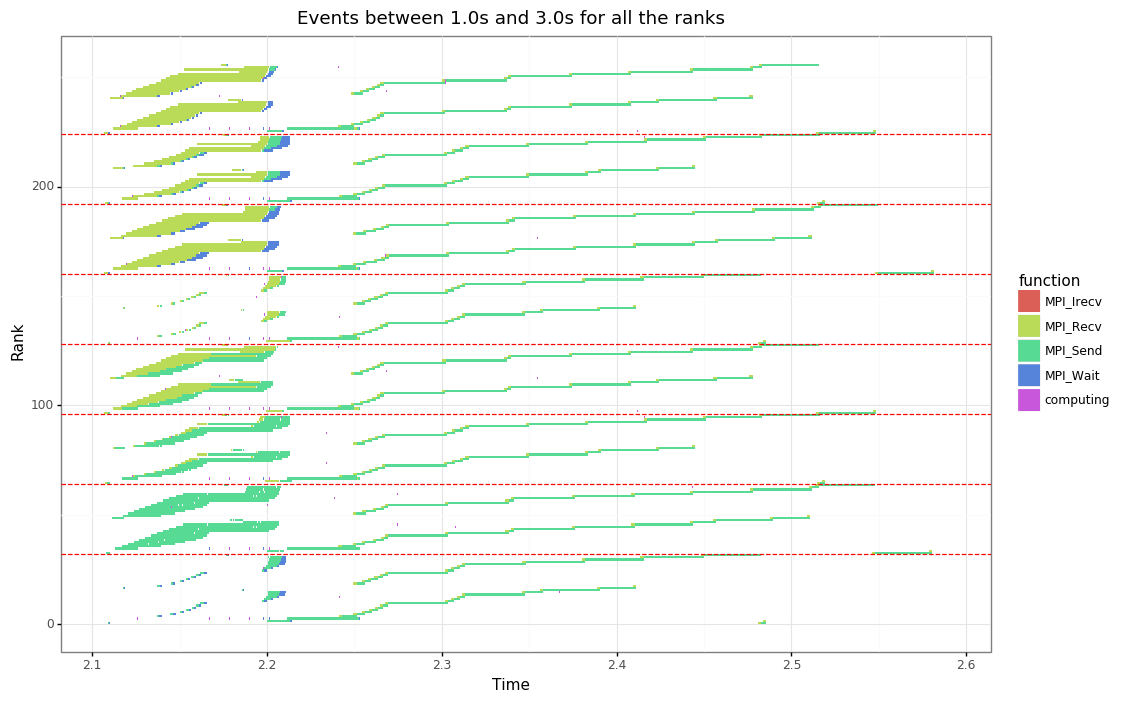

<ggplot: (8785595299220)>


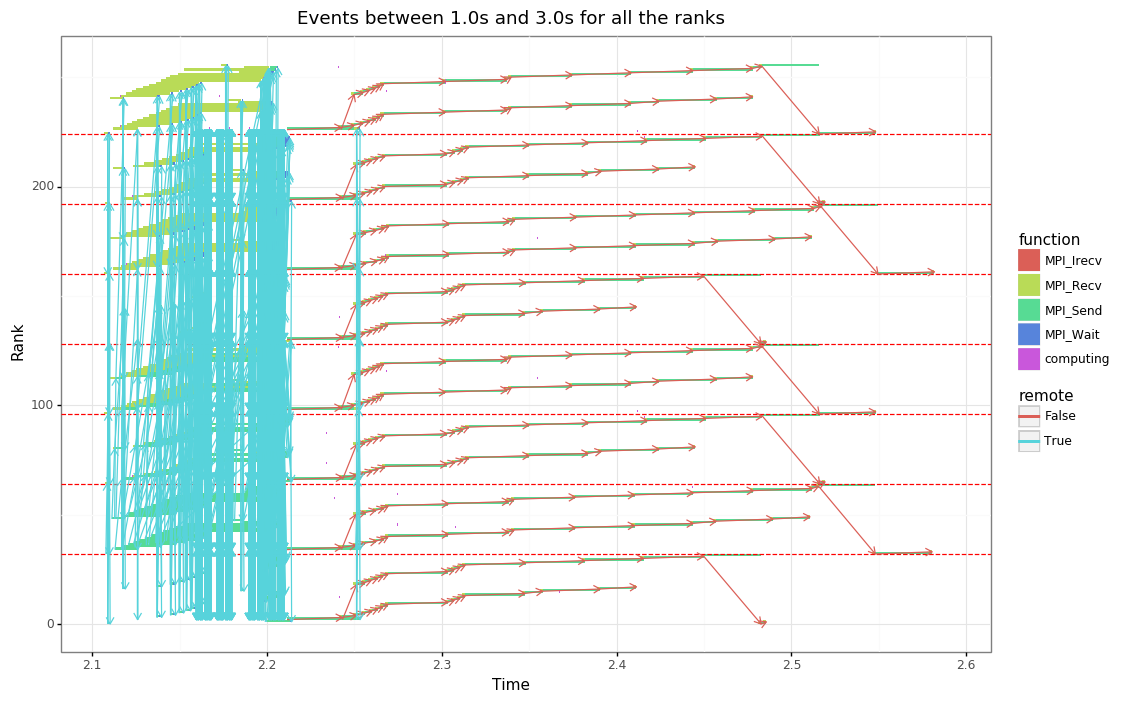

<ggplot: (8785595299220)>


In [7]:
draw_plot(df_state, df_link, time_interval=(1, 3))

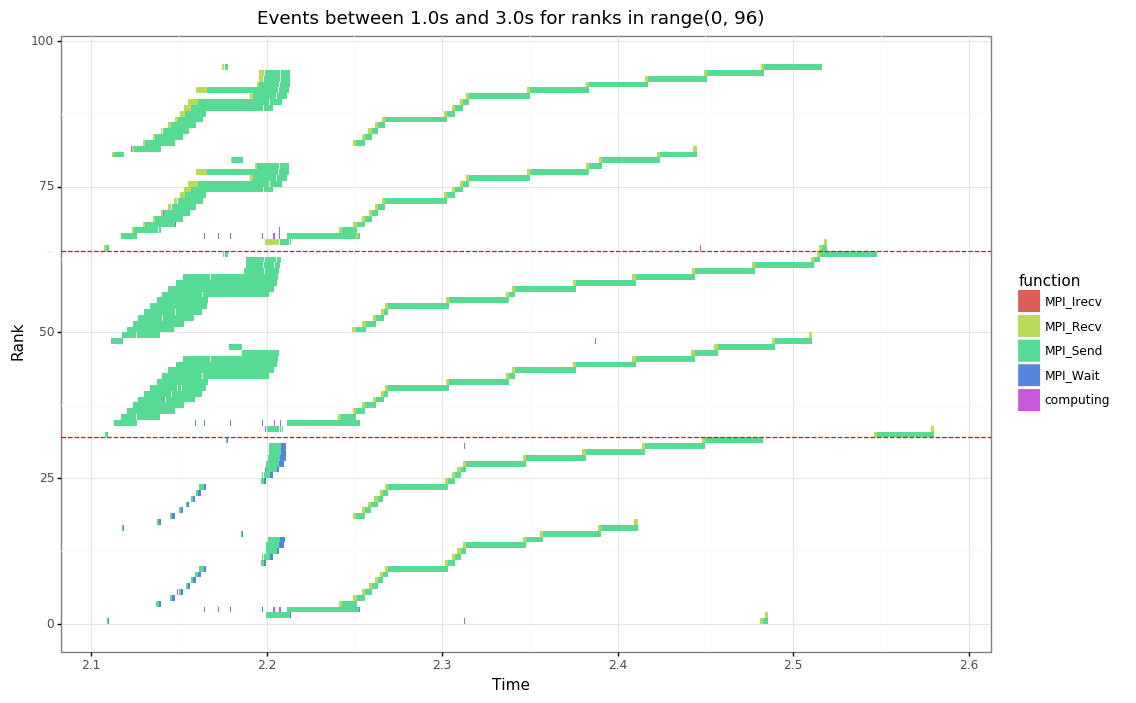

<ggplot: (-9223363251259457220)>


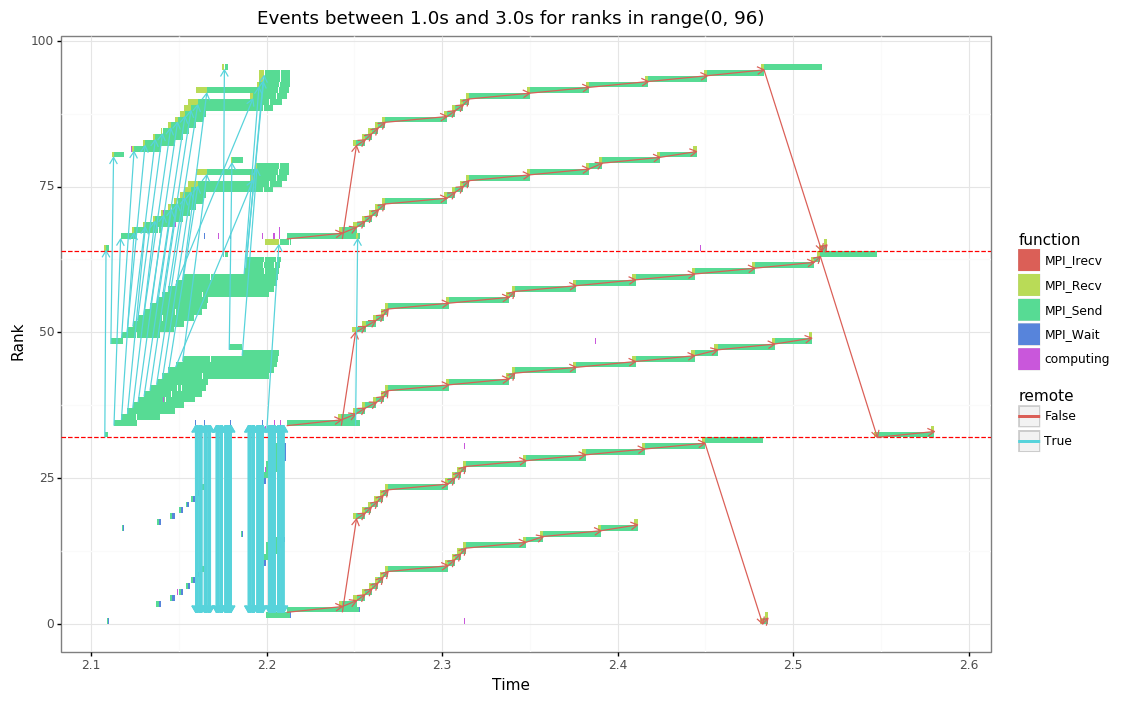

<ggplot: (-9223363251259457220)>


In [8]:
draw_plot(df_state, df_link, time_interval=(1, 3), ranks=range(0, 96))

In [9]:
import os

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    experiment = os.path.splitext(os.path.basename(zip_name))[0]
    if 'smpi' not in experiment:
        experiment = 'real'
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
    df = result['exp/exp_PingPong.csv']
    pingpong_send = df[df.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df[df.op=='MPI_Recv'].reset_index(drop=True)
    df = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration,
                       experiment = pingpong_send.experiment,
                  ))
    result['exp/exp_PingPong.csv'] = df
    result['MPI_Send'] = pingpong_send
    result['MPI_Recv'] = result['exp/exp_Recv.csv']
    return result

result_calibration_smpi = extract_zip('../mpi/smpi_fixed.zip')

In [10]:
def get_dataframes(df_hpl, dict_calibration, function):
    df_calibration = dict_calibration[function][['duration', 'msg_size']].copy()
    df_hpl = df_hpl[df_hpl['function'] == function][['duration', 'msg_size']].copy()
    df_calibration['origin'] = 'calibration'
    df_hpl['origin'] = 'hpl'
    df = pandas.concat([df_hpl, df_calibration])
    return df

def plot_comparison(df_hpl, dict_calibration, function, aggregate=False):
    df = get_dataframes(df_state, result_calibration_smpi, 'MPI_Recv')
    title = 'Duration of %s' % function
    return ggplot(df, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1) + scale_x_log10() + scale_y_log10() + theme_bw() + ggtitle(title)

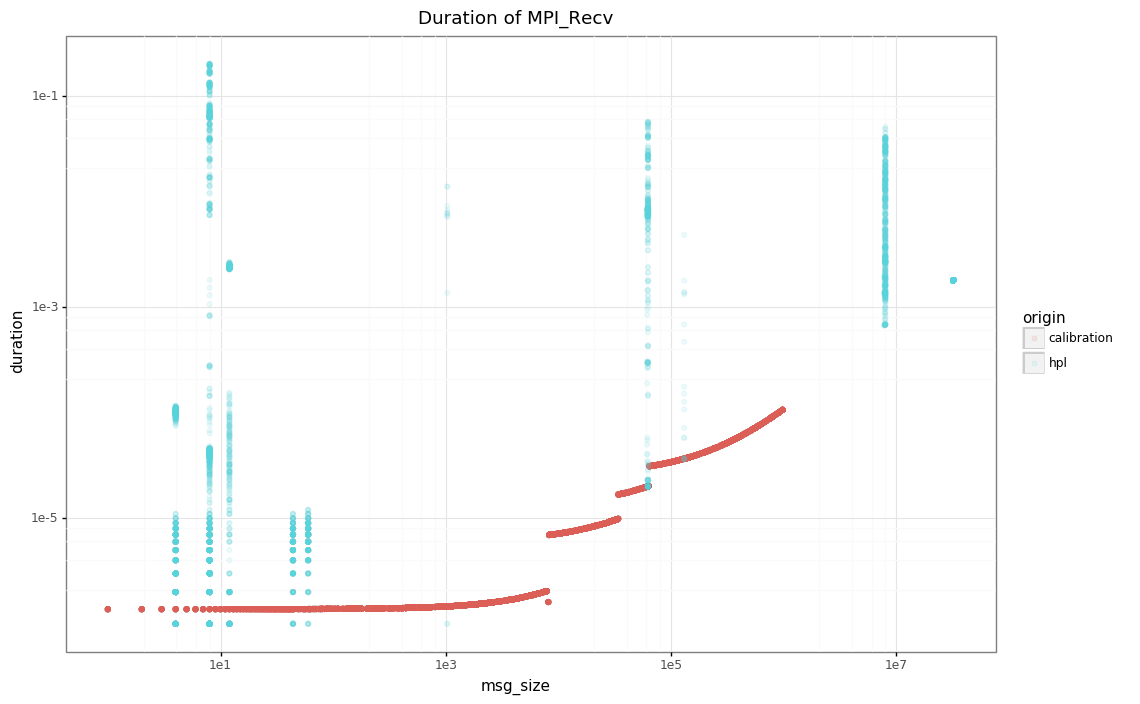

<ggplot: (8785589525894)>

In [11]:
plot_comparison(df_state, result_calibration_smpi, 'MPI_Recv')

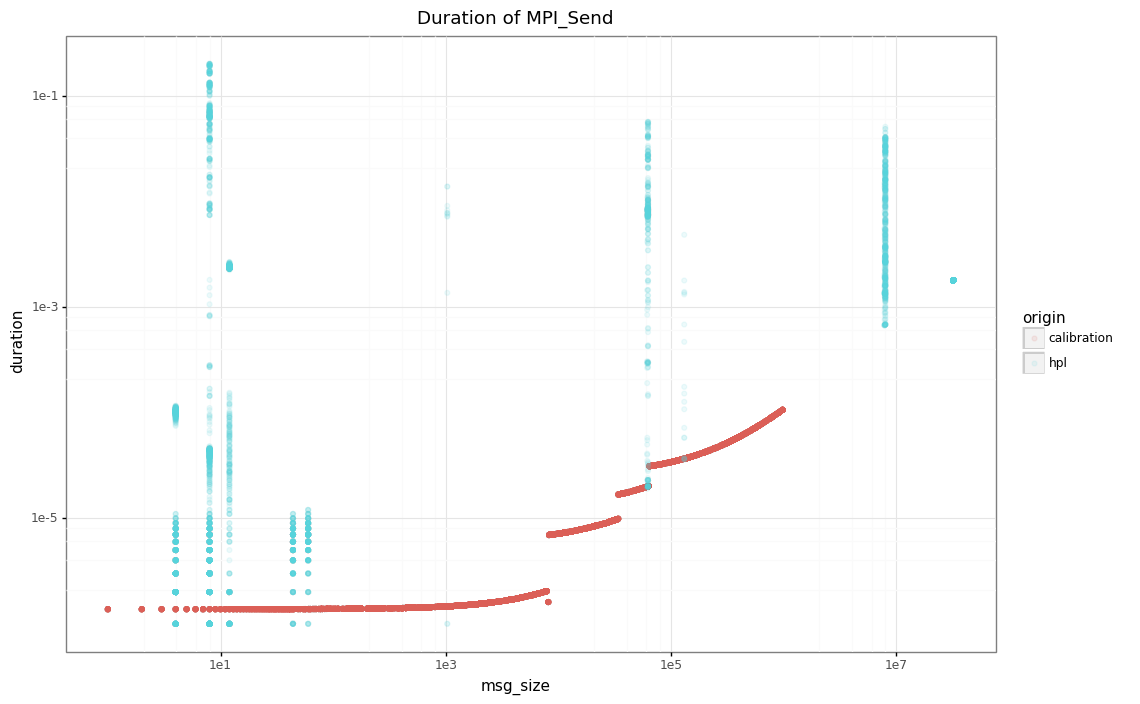

<ggplot: (-9223363251283682402)>

In [12]:
plot_comparison(df_state, result_calibration_smpi, 'MPI_Send')